# Red Light Camera Analysis

Linear regression analysis of factors affecting red light violations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
# import dask
# import dask.dataframe as dd
import gc

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('int_startend',), ('intersection_chars',), ('all_hours',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injur

## Query our data
I would like to get daily red light camera intersection data with the following columns:
- violations
- weekday
- month
- year
- region   (can add this post query with lambda function from intersection_cams and region_data tables, ugh!)
- congestion (try peak, rush hour, average, etc)
- precipitation
- max_temp



In [4]:
# LINK daily_violations to hourly_congestion through intersection_cams
int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                SUM(violations) as violations,
                                                month,
                                                day,
                                                year
                                        FROM daily_violations
                                        GROUP BY year, month, day, intersection
                                        ),
                                    
                                    ic as
                                        (SELECT region_id,
                                                intersection
                                         FROM intersection_cams
                                        ),
                                        
                                    c as
                                        (SELECT AVG(speed) as speed,
                                                region_id,
                                                month,
                                                day,
                                                weekday,
                                                year    
                                         FROM hourly_congestion
                                         GROUP BY year, month, day, region_id
                                        )
                                    SELECT  v.*,
                                            ic.region_id,
                                            c.speed
                                    FROM v
                                    LEFT JOIN ic
                                      ON v.intersection = ic.intersection
                                    LEFT JOIN c
                                      ON c.year = v.year
                                          AND c.month = v.month
                                          AND c.day = v.day
                                          AND c.region_id = ic.region_id
                                      
                                    WHERE v.year > 2015
                                    ORDER BY v.year, v.month, v.day, ic.region_id
                                    ''', conn)

In [5]:


# NOW LET'S ADD WX
# -temp
# -rain_1h
# -rain_3h
# -snow_1h
# -snow_3h
# -time
# -year
# -month
# -day
# -hour
# -weekday
int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                SUM(violations) as violations,
                                                month,
                                                day,
                                                year
                                        FROM daily_violations
                                        GROUP BY year, month, day, intersection
                                        ),
                                    
                                    ic as
                                        (SELECT region_id,
                                                intersection
                                         FROM intersection_cams
                                        ),
                                        
                                    c as
                                        (SELECT AVG(speed) as speed,
                                                MIN(speed) as min_speed,
                                                region_id,
                                                month,
                                                day,
                                                weekday,
                                                year    
                                         FROM hourly_congestion
                                         GROUP BY year, month, day, region_id
                                        ),
                                        
                                     wx as
                                        (SELECT temp,
                                                SUM(snow_1h)+SUM(rain_1h) as precip,
                                                month,
                                                day,
                                                weekday,
                                                year    
                                         FROM hourly_weather
                                         GROUP BY year, month, day
                                        )
                                    SELECT  v.*,
                                            CAST(ic.region_id as INT) as region_id,
                                            CAST(c.speed as REAL) as speed, 
                                            CAST(c.min_speed as REAL) as min_speed,
                                            CAST(wx.weekday as INT) as weekday,
                                            CAST(wx.precip as REAL) as precip,
                                            CAST(wx.temp as REAL) as temp
                                    FROM v
                                    LEFT JOIN ic
                                      ON v.intersection = ic.intersection
                                    LEFT JOIN c
                                      ON c.year = v.year
                                          AND c.month = v.month
                                          AND c.day = v.day
                                          AND c.region_id = ic.region_id
                                    LEFT JOIN wx
                                      ON wx.year = v.year
                                          AND wx.month = v.month
                                          AND wx.day = v.day
                                    WHERE v.year > 2015
                                    ORDER BY v.year, v.month, v.day, ic.region_id
                                    ''', conn)

# LOOKS GOOD!!
print(int_df.info())
int_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267861 entries, 0 to 267860
Data columns (total 11 columns):
intersection    267861 non-null object
violations      267861 non-null int64
month           267861 non-null int64
day             267861 non-null int64
year            267861 non-null int64
region_id       267861 non-null int64
speed           262415 non-null float64
min_speed       262415 non-null float64
weekday         260808 non-null float64
precip          260808 non-null float64
temp            260808 non-null float64
dtypes: float64(5), int64(5), object(1)
memory usage: 22.5+ MB
None


,intersection,violations,month,day,year,region_id,speed,min_speed,weekday,precip,temp
0,WESTERN AND TOUHY,5,1,2,2016,1,23.016597,19.998333,5.0,0.0,273.262
1,CICERO AND CHICAGO,4,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
2,CICERO AND HARRISON,7,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
3,CICERO AND WASHINGTON,2,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
4,HAMLIN AND LAKE,4,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
5,HAMLIN AND MADISON,6,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
6,PULASKI AND DIVISION,6,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
7,ROOSEVELT AND PULASKI,7,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
8,SACRAMENTO AND CHICAGO,7,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262
9,SACRAMENTO AND LAKE,4,1,2,2016,10,22.764375,20.111667,5.0,0.0,273.262


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [6]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'violations'
drop_me = ['day']
categoricals = ['weekday', 'month', 'year', 'region_id', 'intersection']
continuous = ['temp', 'speed', 'min_speed', 'precip']

df_cont = int_df.copy()
df_cont.drop(columns=drop_me+categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print((column.upper() + " ") * 5)
    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    #fig, axes = plt.subplots(figsize=(15,12))
    #fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    #fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    #fig.tight_layout()
    #plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

VIOLATIONS VIOLATIONS VIOLATIONS VIOLATIONS VIOLATIONS 
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.569e+32
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:41:51   Log-Likelihood:             7.4022e+06
No. Observations:              267861   AIC:                        -1.480e+07
Df Residuals:                  267859   BIC:                        -1.480e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
3,precip,0.000566,1.076255e+01,-0.048787,5.626316e-34,5.007857e+06
1,speed,0.003703,1.725633e+01,-0.278332,9.832125e-214,5.067681e+06
2,min_speed,0.004558,1.493468e+01,-0.219430,1.058139e-262,5.039970e+06
4,temp,0.012626,-2.318050e+01,0.117727,0.000000e+00,5.036406e+06
0,violations,1.000000,-3.048950e-13,1.000000,0.000000e+00,5.190864e+06


In [7]:
# scatter plot takes a few min

# pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
# plt.show()

In [8]:
df_cont.corr()  # create a correlation matrix

,violations,speed,min_speed,precip,temp
violations,1.000000,-0.060855,-0.067515,-0.023791,0.112367
speed,-0.060855,1.000000,0.837729,-0.008242,0.035591
min_speed,-0.067515,0.837729,1.000000,0.002566,0.012933
precip,-0.023791,-0.008242,0.002566,1.000000,0.072289
temp,0.112367,0.035591,0.012933,0.072289,1.000000


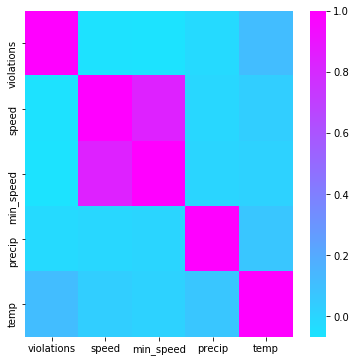

In [9]:
import seaborn as sns

plt.figure(figsize = (6,6))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [ ]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = int_df.drop(columns=continuous+[target, 'weekday', 'region_id', 'day'])
df_contcontinuous = df_continuous.drop(columns=['speed'])

string_me = ['month', 'year']
df_ohe[string_me] = df_ohe[string_me].astype(str)

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [16]:
pd.options.display.max_columns = 100
df_final.columns

Index(['violations', 'speed', 'min_speed', 'precip', 'temp',
       'intersection_115TH AND HALSTED', 'intersection_119TH AND HALSTED',
       'intersection_31ST ST AND MARTIN LUTHER KING DRIVE',
       'intersection_35TH AND WESTERN', 'intersection_4700 WESTERN',
       ...
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'year_2017',
       'year_2018', 'year_2019', 'year_2020', 'year_2021'],
      dtype='object', length=179)

In [17]:
df_final.dropna(inplace=True)

In [18]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression



X = df_final.drop(['violations'], axis=1)
y = df_final['violations']
reg = LinearRegression().fit(X, y)  # my regression object


# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
reg.fit(X, y)
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('Baseline r_squared val:', baseline)

       speed: 0.5741670704793902
   min_speed: -0.11859863179504615
      precip: -0.04909068717846238
        temp: 0.032146601926278606
intersection_115TH AND HALSTED: 2.8413071835696426
intersection_119TH AND HALSTED: -0.7372751676913794
intersection_31ST ST AND MARTIN LUTHER KING DRIVE: 2.7021841394808837
intersection_35TH AND WESTERN: -4.441145267471409
intersection_4700 WESTERN: -3.40436961507503
intersection_55TH AND KEDZIE: -6.346658265938412
intersection_55TH AND WESTERN: -1.4436558637192238
intersection_55TH and PULASKI: -5.851072523802101
intersection_63RD AND STATE: 6.84779847348777
intersection_71ST AND ASHLAND: -2.109953893066885
intersection_75TH AND STATE: 17.139428137810672
intersection_79TH AND HALSTED: -1.9741392208843775
intersection_79TH AND KEDZIE: -7.042639932299569
intersection_87TH AND VINCENNES: 11.721409191576285
intersection_95TH AND STONEY ISLAND: -2.0641716433814348
intersection_99TH AND HALSTED: 16.9684320410823
intersection_ADDISON AND HARLEM: -5.0263010

In [19]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))


#preprocessed.columns 
baseline

0.7191621079978603

I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

In [15]:
# camera




int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)

DatabaseError: Execution failed on sql '
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ': no such column: dat